In [2]:
! pip install hummingbird-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.0/151.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl 

In [2]:
! pip install onnx-tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import joblib
import hummingbird.ml


from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
from sklearn.linear_model import LinearRegression,Ridge,Lasso #Ridge: Regularisasi L2 (cegah satu fitur untuk punya efek dominan), Lasso: regularisasi L1, regularisasi biasa
from sklearn.tree import DecisionTreeRegressor #Tree model untuk regresi
from sklearn.ensemble import RandomForestRegressor #Random forest
from sklearn.metrics import mean_squared_error,r2_score
from onnx_tf.backend import prepare

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [23]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Main objectives




*   Quickly load data, train average price prediction them on few types of models.
*   Plot performance
*   Convert to tfjs-compatible json


In [ ]:
#sequential feature selection, seleksi feature yang berguna buat suatu model.
def sequential_feature_selection(model,X_train,Y_train,X_test):
    sfs = SequentialFeatureSelector(model,  direction='backward', scoring='r2', cv=5)
    sfs.fit(X_train, Y_train)
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)
    return X_train_selected, X_test_selected

In [ ]:
#Fungsi untuk membuat data parameter Gradient Boost Regressor
def GBParamBuilder(n_estimator=500, max_depth=4, min_sample_split=5, lr=0.01, loss="squared_error"):
  return params = {
    "n_estimators": n_estimator,
    "max_depth": max_depth,
    "min_samples_split": min_sample_split,
    "learning_rate": lr,
    "loss": loss,
}

## Trees & Ensemble

In [ ]:
def GBRTrain(X, y, params ): #Gradient Boost Regressor
  model = ensemble.GradientBoostingRegressor(**params)
  model.fit(X,y)
  return model
def RFRTrain(X, y, n_estimator, max_depth ): #Random Forest Regressor
  model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth)
  model.fit(X,y)
  return model
def DTRTrain(X, y): #Decision Tree Regressor
  model = DecisionTreeRegressor()
  model.fit(X,y)
  return model

## Regression

In [ ]:
def LTrain(X,y): #Lasso Regression #might require sfs
  model = Lasso()
  model.fit(X,y)
  return model
def RTrain(X,y): #Ridge Regression #might require sfs
  model = Ridge()
  model.fit(X,y)
  return model
def LRTrain(X,y): #Linear Regression, #might require sfs
  model = LinearRegression()
  model.fit(X,y)
  return model

## Data Loading and cleaning stuff

In [6]:
#SAMPLE DATA
df = pd.read_csv("/content/UnitToAverageBaselinePrice_2024_05_20.csv")
df.head()

,unit_id,average_baseline_price,number_of_bookings,property_id,bedroom,bathroom,beds,capacity,ac,balcony,...,private_entrance,shampoo,tv,washer,wifi,workspace,lat,lng,area_id,area_name
0,UN0026,388196.713861,98,PR0017,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,-8.656211,115.132867,A0003,Canggu
1,UN0027,432090.909091,33,PR0017,1.0,1.0,1.0,2.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,-8.656211,115.132867,A0003,Canggu
2,UN0043,727306.000000,5,PR0352,2.0,2.0,2.0,4.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,NaN,NaN,A0020,Nusa Penida
3,UN0120,394565.800452,34,PR0261,3.0,NaN,NaN,NaN,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,A0009,Balangan
4,UN0121,369575.785794,30,PR0261,1.0,NaN,NaN,NaN,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,A0009,Balangan


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   unit_id                 880 non-null    object 
 1   average_baseline_price  880 non-null    float64
 2   number_of_bookings      880 non-null    int64  
 3   property_id             880 non-null    object 
 4   bedroom                 878 non-null    float64
 5   bathroom                582 non-null    float64
 6   beds                    582 non-null    float64
 7   capacity                523 non-null    float64
 8   ac                      539 non-null    float64
 9   balcony                 539 non-null    float64
 10  beachfront              539 non-null    float64
 11  breakfast               539 non-null    float64
 12  building_staff          539 non-null    float64
 13  cable_tv                539 non-null    float64
 14  essentials              539 non-null    fl

In [8]:
#dont need to run this one
unique_values = df['area_name'].unique()

# Convert the unique values to a DataFrame
unique_df = pd.DataFrame(unique_values, columns=['area_names'])

# Save the DataFrame to a new CSV file
unique_df.to_csv('area_names.csv', index=False)

In [28]:
data = df.drop(columns=['lat','lng', 'area_id', 'unit_id', 'property_id'])
data = data.dropna(subset=['bedroom', 'bathroom', 'beds','capacity'])

In [29]:
data = data.dropna()

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 516 entries, 0 to 871
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   average_baseline_price  516 non-null    float64
 1   number_of_bookings      516 non-null    int64  
 2   bedroom                 516 non-null    float64
 3   bathroom                516 non-null    float64
 4   beds                    516 non-null    float64
 5   capacity                516 non-null    float64
 6   ac                      516 non-null    float64
 7   balcony                 516 non-null    float64
 8   beachfront              516 non-null    float64
 9   breakfast               516 non-null    float64
 10  building_staff          516 non-null    float64
 11  cable_tv                516 non-null    float64
 12  essentials              516 non-null    float64
 13  garden                  516 non-null    float64
 14  gym                     516 non-null    float64

In [22]:
data.head()

,average_baseline_price,number_of_bookings,bedroom,bathroom,beds,capacity,ac,balcony,beachfront,breakfast,...,luggage_drop_off,parking,pool,private_entrance,shampoo,tv,washer,wifi,workspace,area_name
0,388196.713861,98,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,Canggu
1,432090.909091,33,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,Canggu
2,727306.000000,5,2.0,2.0,2.0,4.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,Nusa Penida
5,744021.936878,393,1.0,1.0,1.0,3.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,Uluwatu
6,548098.368546,186,1.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,Uluwatu


In [31]:
column_to_encode = 'area_name'
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(data[[column_to_encode]])

# Get the one-hot encoded column names
encoded_column_names = encoder.get_feature_names_out([column_to_encode])

# Create a DataFrame with the one-hot encoded columns
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_column_names)

# Drop the original column from the original DataFrame
data = data.drop(columns=[column_to_encode])

# Concatenate the one-hot encoded columns with the original DataFrame
data = pd.concat([data, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
data = data.dropna()

# General Training

In [33]:
def load_dataset(dataset):
  #Function that can receive csv data, turn the features and labels into numpy variables, and returns a tuple of (X, y)
  X = dataset.drop(columns=['average_baseline_price']).values
  y = dataset['average_baseline_price'].values
  return (X,y)

In [34]:
TEST_RATIO = 0.25
RANDOM_STATE = 37

In [35]:
def TrainFitPredict(model,iterations,X, y,X_test ,y_test): #Takes in split dataset, returns test scores and train history.
  model.fit(X,y)
  test_score = np.zeros((iterations,), dtype=np.float64)
  for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)
  return test_score, model.train_score_

In [36]:
def PlotPerformance(test_scores, train_scores): #plots training + test by receiving test and training scores provided by TrainFitPredict
  fig = plt.figure(figsize=(6, 6))
  plt.subplot(1, 1, 1)
  plt.title("MSE")
  plt.plot(
      np.arange(len(train_scores)) + 1,
      train_scores,
      "b-",
      label="Training Set Deviance",
  )
  plt.plot(
      np.arange(len(test_scores)) + 1, test_scores, "r-", label="Test Set Deviance"
  )
  plt.legend(loc="upper right")
  plt.xlabel("Boosting Iterations")
  plt.ylabel("Deviance")
  fig.tight_layout()
  plt.show()

In [44]:
#DATA PREP
RANDOM_STATE = 13
dataset = load_dataset(data)
X, y = dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=RANDOM_STATE)

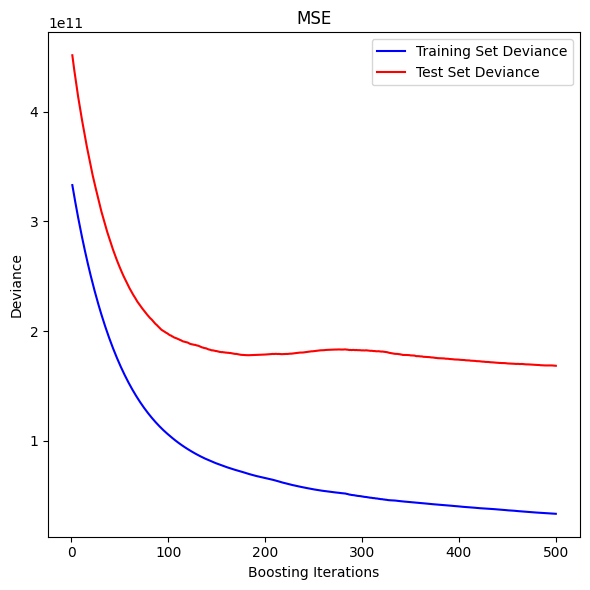

In [45]:

params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
reg = ensemble.GradientBoostingRegressor(**params)
test_scores, train_scores = TrainFitPredict(reg, params['n_estimators'], X_train, y_train, X_test, y_test) #All datas are in ndarrays.
PlotPerformance(test_scores, train_scores)

## Convert to tfjs compatbile format.